<a href="https://colab.research.google.com/github/KeyMoney22/Plant_disease_classification-/blob/EfficientNetB0/tomato_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importing Relevant Libraries

In [2]:
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras import models, layers

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to your folder
folder_path = '/content/drive/MyDrive/PlantVillage'

Mounted at /content/drive


## 2. Loading our dataset.

In [5]:
data= tf.keras.utils.image_dataset_from_directory(folder_path, labels='inferred', label_mode='categorical',
                                            class_names=None, color_mode='rgb', batch_size=32,
                                            image_size=(256, 256), shuffle=True, seed=None,
                                            validation_split=None, subset=None, interpolation='bilinear',
                                            follow_links=False, crop_to_aspect_ratio=False)

Found 16011 files belonging to 10 classes.


In [6]:
# Checking and printing the length of our data
print('The length of our data is', len(data))

# Checking the shape of our images and labels
for image_batch, label_batch in data:
  print('Image Batch Shape', image_batch.shape)
  print('Label Batch Shape', label_batch.shape)
  break
  #3 = rgb
  #32 = batch size
  # 256, 256= height , weight

The length of our data is 501
Image Batch Shape (32, 256, 256, 3)
Label Batch Shape (32, 10)


### Visualizing some of our images

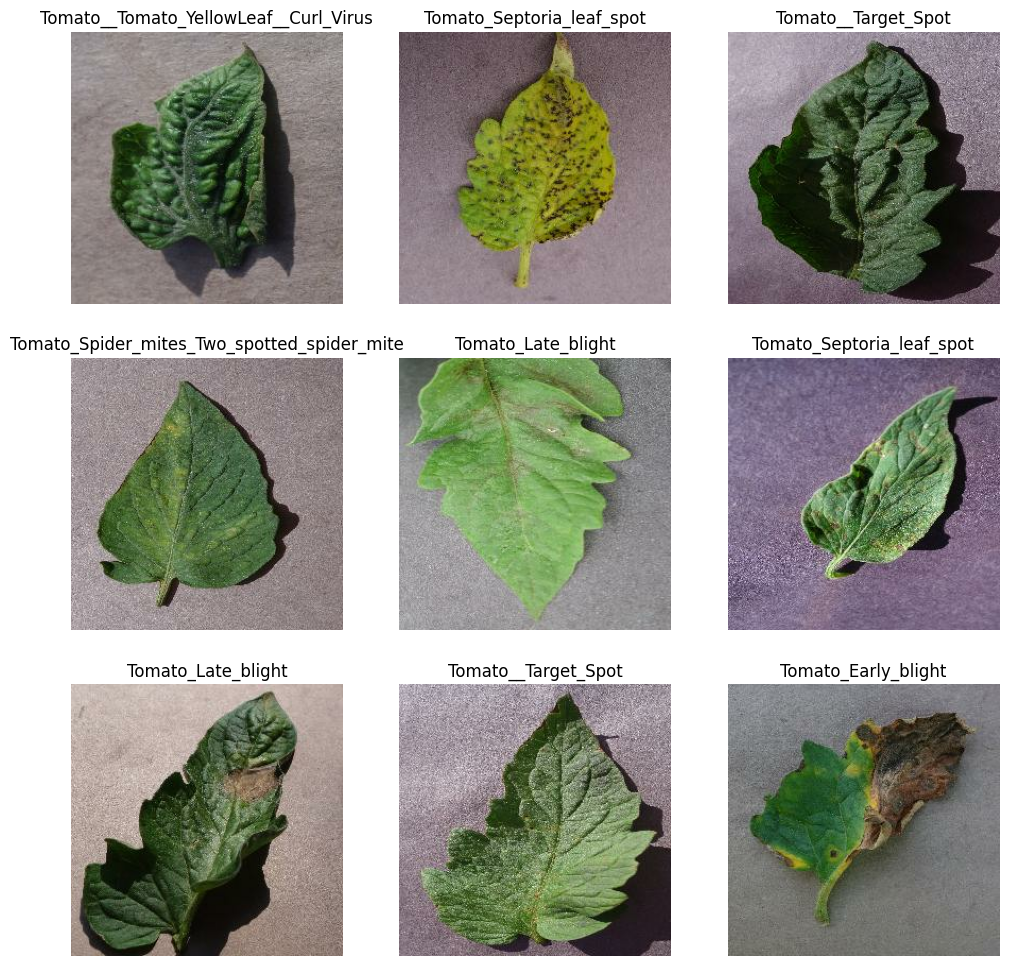

In [7]:
def preview_data(dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")#hide the numbers
    plt.show()

class_names = data.class_names
preview_data(data, class_names)


## 3. Data Cleaning and Preperation

**Cleaning the class names**

In [8]:
#Checking our class names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [9]:
# Cleaning and printing the formarted class names
def clean_class_name(name):
    name = name.replace('__', '_')
    name = name.replace('__', '_')
    if name == 'Tomato_Spider_mites_Two_spotted_spider_mite':
        name = 'Tomato_Spider_mites'
    elif name == 'Tomato_Tomato_YellowLeaf_Curl_Virus':
        name = 'Tomato_Yellow_Leaf_Curl_Virus'
    elif name == 'Tomato_Tomato_mosaic_virus':
        name = 'Tomato_Mosaic_Virus'
    name = name.lower()
    return name

class_names = [clean_class_name(name) for name in class_names]
class_names

['tomato_bacterial_spot',
 'tomato_early_blight',
 'tomato_late_blight',
 'tomato_leaf_mold',
 'tomato_septoria_leaf_spot',
 'tomato_spider_mites',
 'tomato_target_spot',
 'tomato_yellow_leaf_curl_virus',
 'tomato_mosaic_virus',
 'tomato_healthy']

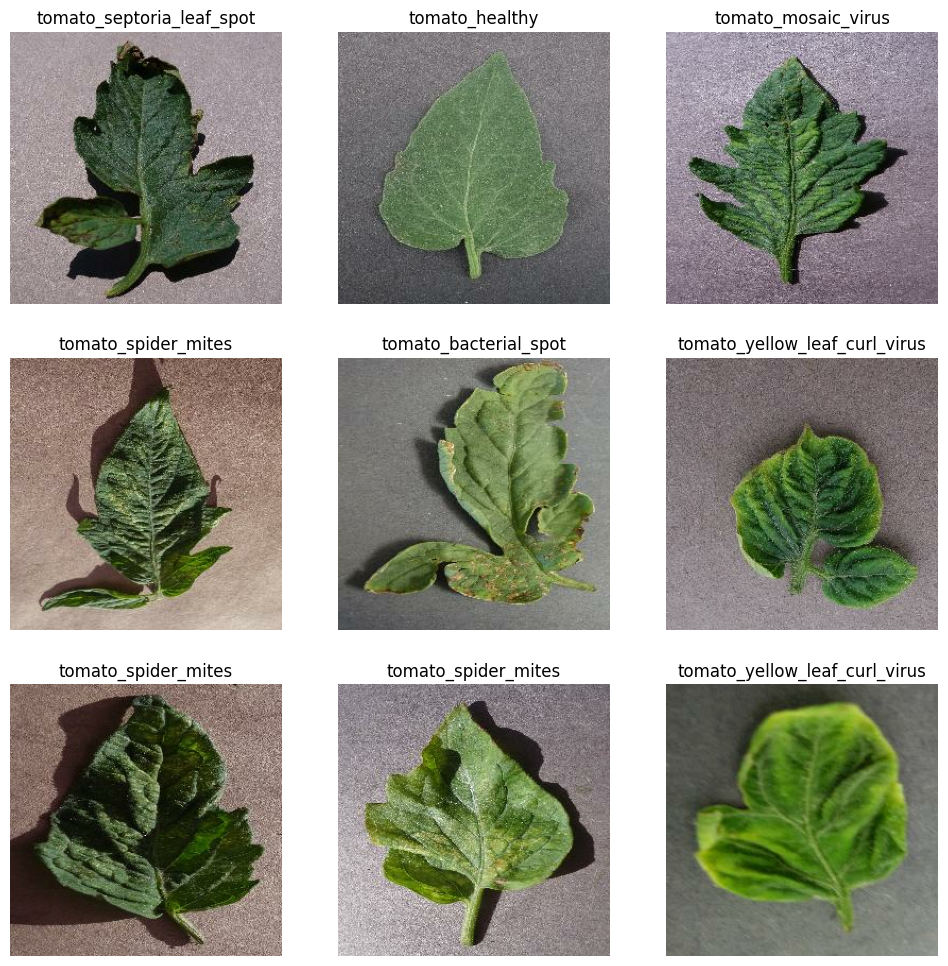

In [10]:
preview_data(data, class_names)

**Checking for Corrupt images**

In [12]:
# def check_corrupt_images(folder_path):
#     corrupt_images = []
#     for root, _, files in os.walk(folder_path):
#         for file in files:
#             try:
#                 img = Image.open(os.path.join(root, file))
#                 img.verify()  # Verify that it is, in fact, an image
#             except (IOError, SyntaxError) as e:
#                 corrupt_images.append(os.path.join(root, file))
#     return corrupt_images

# corrupt_images = check_corrupt_images(folder_path)
# print(f"Found {len(corrupt_images)} corrupt images.")

In [13]:
# # Removing Corrupt images
# for img_path in corrupt_images:
#     try:
#       os.remove(img_path)
#       print(f"Corrupt image removed:{img_path}")
#     except OSError:
#       pass

**Class Distribution**

In [14]:
# A function to check class distribution
def check_class_distribution(dataset):
    class_counts = {}
    for images, labels in dataset:
        for label in labels:
            class_name = class_names[tf.argmax(label)]
            if class_name in class_counts:
                class_counts[class_name] += 1
            else:
                class_counts[class_name] = 1
    return class_counts

# Checking class distribution
class_distribution = check_class_distribution(data)

# Sorting the dictionary by values (class counts) in ascending order
sorted_class_distribution = dict(sorted(class_distribution.items(), key=lambda item: item[1]))

print("Sorted class distribution (ascending):", sorted_class_distribution)


KeyboardInterrupt: 

In [ ]:
# Visualize class distribution with a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(list(sorted_class_distribution.keys()), list(sorted_class_distribution.values()), color='Teal')
plt.title('Class Distribution')
plt.xlabel('Frequency')
plt.ylabel('Class')
plt.show();

In our dataset, there is Class imbalance as observed in the graph above, leaf_curl_virus has the highest number of 3208 while tomato mosaic virus with the least observations of 373 as seen on the graph above.

**Splitting our data set**

In [11]:
# Creating a split of our data into train, validation and 80% ,10% and 10% Respectivly
def split_data(data, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):
  # Calculating the length of our dataset
  data_size = len(data)
  if shuffle:
    data = data.shuffle(shuffle_size) #Shuffling our data
  train_size = int(train_split* len(data))
  val_size = int(val_split*len(data))

  train_set = data.take(train_size)
  val_set = data.skip(train_size).take(val_size)
  test_set = data.skip(train_size).skip(val_size)

  return train_set, val_set, test_set


#Creating Data Subsets

# Define the get_subset function if it's not defined elsewhere
def get_subset(dataset, fraction):
  """
  Returns a subset of the given dataset.

  Args:
    dataset: The dataset to extract a subset from.
    fraction: The fraction of the dataset to return.

  Returns:
    A subset of the original dataset.
  """
  subset_size = int(len(dataset) * fraction)
  return dataset.take(subset_size)

# Assuming 'data' is your original dataset, call split_data to define train_set, val_set, and test_set
train_set, val_set, test_set = split_data(data) # Replace 'data' with your actual dataset variable

train_subset = get_subset(train_set, 1/3)
val_subset = get_subset(val_set, 1/3)
test_subset = get_subset(test_set, 1/3)


In [12]:
# Printing the length of our train, validation and test data
train_set, val_set, test_set = split_data(data)
print(len(train_set))
print(len(val_set))
print(len(test_set))

400
50
51


In [13]:
# Printing the length of our train, validation and test data subsets
train_set, val_set, test_set = split_data(data)
print(len(train_subset))
print(len(val_subset))
print(len(test_subset))

133
16
17


# Data Modeling

**Resizing, Rescaling and Augmentation**

In [18]:
img_size = 224

# Creating an instance to Resize our data
resize_and_rescale = tf.keras.Sequential([
                layers.Resizing(img_size,img_size),
                layers.Rescaling(1.0/255)
])

# Creating a data augmentation instance for our data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)

])

**Augmenting the Train data and Caching our data**

In [19]:
#Augmenting our train_data
train_set = train_set.map(lambda x, y: (data_augmentation(x, training=True), y))

# Caching our data
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


#Augmenting our train_data
train_subset = train_subset.map(lambda x, y: (data_augmentation(x, training=True), y))

#Data Subset
train_subset = train_subset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_subset = val_subset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_subset = test_subset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)





**EfficientNet**

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 efficientnet-b0 (Functiona  (None, 7, 7, 1280)        4049564   
 l)                                                              
                                                                 
 global_average_pooling2d_2  (32, 1280)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (32, 128)                 163968    
                                                                 
 dense_7 (Dense)             (32, 32)                  4128      
                                                                 
 dropout_2 (Dropout)         (32, 32)                 

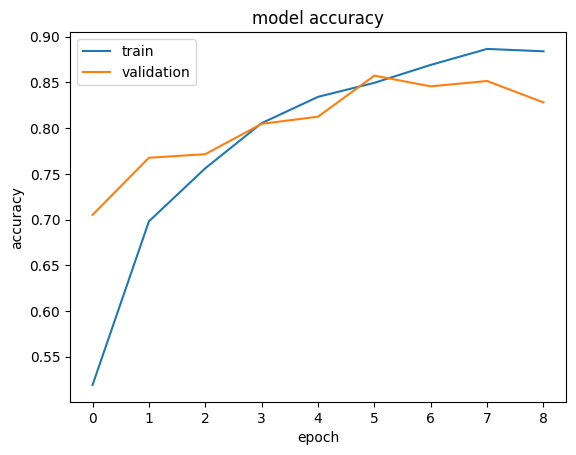

51/51 [==============================] - 40s 306ms/step - loss: 0.4848 - accuracy: 0.8388
Test Loss: 0.4848070740699768
Test Accuracy: 0.8388480544090271


In [20]:
# Loading the EfficientNetB0 model pre-trained on ImageNet, with the top layers removed
!pip install efficientnet
import efficientnet.tfkeras as efn
from tensorflow.keras.callbacks import EarlyStopping



# Defining the EfficientNet Base model
base_model = efn.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
    )

# Freezing the base model
base_model.trainable = False

# Change the final layer to match the number of unique labels
num_classes = 10

# Custom layers on top of the base model
model = models.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    # layers.Dense(256, activation='relu'),
    # layers.Dense(128, activation='relu'),
    # layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model(next(iter(train_set))[0])

# Defining the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor ='val_accuracy',  # Monitor validation accuracy
    patience = 3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary to verify parameter counts
model.summary()

# Train the model
epochs = 50
history_efn = model.fit(train_subset,
                 epochs=epochs,
                 validation_data=val_subset,
                 callbacks=[early_stopping]
               #  class_weight=class_weights
                 )

# Visualizing our accuracy and validation scores

def plot_hist(hist):
    plt.plot(history_efn.history["accuracy"])
    plt.plot(history_efn.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history_efn)

# #Evaluating our model
# loss, accuracy = model.evaluate(test_set)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

#Evaluating our model
loss, accuracy = model.evaluate(test_set)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
# prompt: save the above model using keras and export it into a json file

# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

# Export the model to a JSON file
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


**Generating our train and validation data sets**

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define the path to your dataset directory
base_dir = folder_path # r"C:\Users\USER\Documents\Flatiron\phase-5\plant_disease_prediction\PlantVillage"

# Check if the base directory exists
if not os.path.exists(base_dir):
    raise FileNotFoundError(f"The directory {base_dir} does not exist. Please check the path.")

# Define image size and batch size
img_size = 224
batch_size = 32

# Initialize the data generators with 80% training, 10% validation, and 10% test
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1  # Use 10% of data for validation
)

test_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

# Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

# Test Generator
test_generator = test_data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size = batch_size,
    subset='validation',
    class_mode='categorical',
    shuffle=False  # Important: Do not shuffle test data
)

# Print dataset sizes
print(f"Train samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")


Found 14414 images belonging to 10 classes.
Found 1597 images belonging to 10 classes.
Found 1597 images belonging to 10 classes.
Train samples: 14414
Validation samples: 1597
Test samples: 1597


**Efficient Model Version 2**

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 26, 26, 128)     

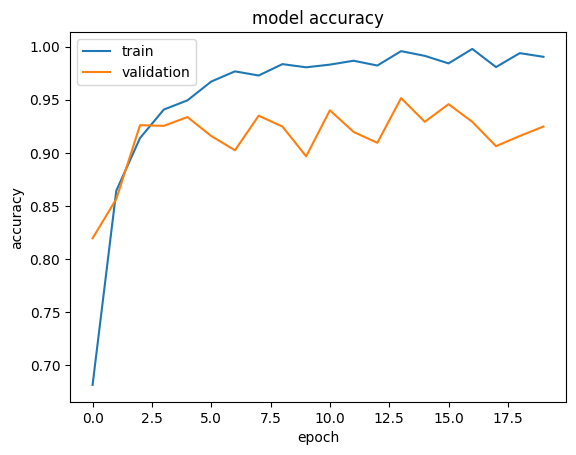

49/49 [==============================] - 7s 145ms/step - loss: 0.4699 - accuracy: 0.9247
Test Loss: 0.4699154794216156
Test Accuracy: 0.9247449040412903


In [33]:
# Model Definition
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

# model summary
model.summary()

# Defining the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor ='val_accuracy',  # Monitor validation accuracy
    patience = 3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              #callbacks =[early_stopping]
              )

# Training the Model
history_efn_2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of steps per epoch
    epochs=20,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size  # Validation steps
)


def plot_hist(hist):
    plt.plot(history_efn_2.history["accuracy"])
    plt.plot(history_efn_2.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(history_efn_2)

# Evaluate model performance
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

In [34]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('efficient_net_model_2.h5')

# Recreate the exact same model, including its weights and the optimizer
efficient_net_model_2 = tf.keras.models.load_model('efficient_net_model_2.h5')

# Show the model architecture
efficient_net_model_2.summary()

# Save the model architecture to JSON
json_config = model.to_json()
with open('model_config.json', 'w') as json_file:
    json_file.write(json_config)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 26, 26, 128)     

**CNN Model**

In [36]:

# # Model Definition
# model_cnn = models.Sequential()

# model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
# model_cnn.add(layers.MaxPooling2D(2, 2))

# model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model_cnn.add(layers.MaxPooling2D(2, 2))

# model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model_cnn.add(layers.MaxPooling2D(2, 2))

# model_cnn.add(layers.Conv2D(256, (3, 3), activation='relu'))
# model_cnn.add(layers.MaxPooling2D(2, 2))

# model_cnn.add(layers.Flatten())
# model_cnn.add(layers.Dense(256, activation='relu'))  # Hidden layer 1
# model_cnn.add(layers.Dense(128, activation='relu'))  # Hidden layer 2
# model_cnn.add(layers.Dense(64, activation='relu'))   # Hidden layer 3
# model_cnn.add(layers.Dense(32, activation='relu'))   # Hidden layer 4

# model_cnn.add(layers.Dense(train_generator.num_classes, activation='softmax'))

# # Model Summary
# model_cnn.summary()

# # Early Stopping Callback
# early_stopping = EarlyStopping(
#     monitor='val_accuracy',
#     patience=3,
#     restore_best_weights=True
# )

# # Compile the Model
# model_cnn.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Training the Model
# history_cnn = model_cnn.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
#     epochs=20,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
#     callbacks=[early_stopping]
# )

# # Plotting Accuracy and Validation Accuracy
# def plot_hist(hist):
#     plt.plot(hist.history["accuracy"])
#     plt.plot(hist.history["val_accuracy"])
#     plt.title("Model Accuracy")
#     plt.ylabel("Accuracy")
#     plt.xlabel("Epoch")
#     plt.legend(["Train", "Validation"], loc="upper left")
#     plt.show()

# plot_hist(history_cnn)

# # Evaluating the Model
# test_loss, test_accuracy = model_cnn.evaluate(test_generator, steps=test_generator.samples // batch_size)
# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")


**Model Evaluation**